In [ ]:
!pip install pmdarima

     |████████████████████████████████| 1.4 MB 28.0 MB/s 
     |████████████████████████████████| 9.8 MB 47.8 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "serif"

from pmdarima import auto_arima
from statsmodels.tsa.statespace.varmax import VARMAX
import numpy as np
from statsmodels.tsa.stattools import adfuller
from sklearn import metrics
from timeit import default_timer as timer
#Determine RMSE
from math import sqrt
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")
from google.colab import drive
drive.mount('/content/drive')
path = "/content/drive/MyDrive/Waseda/4.3 Inaba Zemi/Senior Thesis/Data/"
df1 = pd.read_csv(path +'df_master_final.csv', index_col='date')
df1.index = pd.to_datetime(df1.index)

Mounted at /content/drive


In [ ]:
data = df1.copy()
data = data.drop(columns={'Dead', 'PCR_negative', 'ComparisonPreDay', 'Tested\_MA(7days)', 'Light-Mid\_Symptoms', 'Severe\_Symptoms'})
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 608 entries, 2020-05-02 to 2021-12-30
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Positive\_Rate       608 non-null    float64
 1   Discharged           608 non-null    float64
 2   PCR\_Positive        608 non-null    float64
 3   ComparisonPreSpread  608 non-null    float64
dtypes: float64(4)
memory usage: 23.8 KB


In [ ]:
def timeseries_evaluation_metrics_func(y_true, y_pred):    
    def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [ ]:
def inverse_diff(actual_df, pred_df):
    df_res = pred_df.copy()
    columns = actual_df.columns
    for col in columns: 
        df_res[str(col)+'_1st_inv_diff'] = actual_df[col].iloc[-1] + df_res[str(col)].cumsum()
    return df_res

## 40 Days

In [ ]:
X = data.copy()
train, test = X[0:-40], X[-40:]
cols = list(train.columns)

pq = []
for name, column in train[['Positive\_Rate', 'Discharged', 'PCR\_Positive','ComparisonPreSpread']].iteritems():
    print(f'Searching order of p and q for : {name}')
    stepwise_model = auto_arima(train[name],start_p=1, start_q=1,max_p=10, max_q=10, seasonal=False,
        trace=True,error_action='ignore',suppress_warnings=True, stepwise=True,maxiter=1000)
    parameter = stepwise_model.get_params().get('order')
    print(f'optimal order for:{name} is: {parameter} \n\n')
    pq.append(stepwise_model.get_params().get('order'))

Searching order of p and q for : Positive\_Rate
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5484.292, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4982.407, Time=0.19 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5423.550, Time=0.31 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5242.652, Time=0.55 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-4982.972, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-5425.539, Time=1.11 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-5495.203, Time=0.44 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-5286.883, Time=0.39 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-5498.479, Time=0.34 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-5488.829, Time=0.59 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-5491.233, Time=0.29 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-5494.576, Time=0.91 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-5490.003, Time=0.98 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : 

In [ ]:
df_results_moni = pd.DataFrame()
print('Grid Search Started')
start = timer()
for i in pq:
    if i[0]== 0 and i[2] ==0:
        pass
    else:
        print(f' Running for {i}')
        model = VARMAX(train[['Positive\_Rate', 'Discharged', 'PCR\_Positive','ComparisonPreSpread']], order=(i[0],i[2])).fit(disp=False)
        result = model.forecast(steps = 40)
        inv_res = inverse_diff(data[['Positive\_Rate', 'Discharged', 'PCR\_Positive','ComparisonPreSpread']] , result)
        positive_rate_rmse = np.sqrt(metrics.mean_squared_error(test['Positive\_Rate'], inv_res['Positive\_Rate']))
        df_results_moni = df_results_moni.append({'p': i[0], 'q': i[2], 'RMSE Positive Rate':positive_rate_rmse}, ignore_index=True)
end = timer()
print(f' Total time taken to complete grid search in seconds: {(end - start)}')

Grid Search Started
 Running for (2, 1, 2)
 Running for (2, 1, 2)
 Running for (7, 1, 2)
 Running for (2, 1, 3)
 Total time taken to complete grid search in seconds: 186.724680444


In [ ]:
df_results_moni.sort_values(by = ['RMSE Positive Rate'])

,RMSE Positive Rate,p,q
3,0.021116,2.0,3.0
2,0.022403,7.0,2.0
0,0.023103,2.0,2.0
1,0.023103,2.0,2.0


In [ ]:
# Import modules
from statsmodels.tsa.statespace.varmax import VARMAX
from pmdarima import auto_arima
from sklearn import metrics
from timeit import default_timer as timer
import warnings
warnings.filterwarnings("ignore")

# Prepare the used dataframe
df1 = pd.read_csv('df_master_final.csv', index_col='date')
df1.index = pd.to_datetime(df1.index)
data = df1.copy()
## Drop some columns to truncate the calculation time necessary for VARMA modelling
data = data.drop(columns={'Dead', 'PCR_negative', 'ComparisonPreDay', 'Tested\_MA(7days)',
                          'Light-Mid\_Symptoms', 'Severe\_Symptoms'})]

# Define a function which shows the evaluation metric
def timeseries_evaluation_metrics_func(y_true, y_pred):    
    def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

# Define a function which takes the inverse of a given column in a dataframe
def inverse_diff(actual_df, pred_df):
    df_res = pred_df.copy()
    columns = actual_df.columns
    for col in columns: 
        df_res[str(col)+'_1st_inv_diff'] = actual_df[col].iloc[-1] + df_res[str(col)].cumsum()
    return df_res

# 40Days Prediction
X = data.copy()
train, test = X[0:-40], X[-40:]
cols = list(train.columns)

## Get the lag length by calculating the AIC for all the used features
pq = []
for name, column in train[['Positive\_Rate', 'Discharged', 
                           'PCR\_Positive','ComparisonPreSpread']].iteritems():
    print(f'Searching order of p and q for : {name}')
    stepwise_model = auto_arima(train[name],start_p=1, start_q=1,max_p=10, max_q=10, seasonal=False,
        trace=True,error_action='ignore',suppress_warnings=True, stepwise=True,maxiter=1000)
    parameter = stepwise_model.get_params().get('order')
    print(f'optimal order for:{name} is: {parameter} \n\n')
    pq.append(stepwise_model.get_params().get('order'))

## VARMA modelling for the calculated lags and show the RMSE for the predicted results
df_results_moni = pd.DataFrame()
for i in pq:
    if i[0]== 0 and i[2] ==0:
        pass
    else:
        print(f' Running for {i}')
        model = VARMAX(train[['Positive\_Rate', 'Discharged', 'PCR\_Positive', 
                              'ComparisonPreSpread']], order=(i[0],i[2])).fit(disp=False)
        result = model.forecast(steps = 40)
        inv_res = inverse_diff(data[['Positive\_Rate', 'Discharged', 'PCR\_Positive',
                                     'ComparisonPreSpread']] , result)
        rmse = np.sqrt(metrics.mean_squared_error(test['Positive\_Rate'], inv_res['Positive\_Rate']))
        df_results_moni = df_results_moni.append({'p': i[0], 'q': i[2],
                                                  'RMSE Positive Rate':rmse}, ignore_index=True)

## Sort the models in descending order according to the RMSE
df_results_moni.sort_values(by = ['RMSE Positive Rate'])

## We use the VARMA model which gives the least RMSE value
model = VARMAX(train[['Positive\_Rate', 'Discharged', 'PCR\_Positive',
                      'ComparisonPreSpread']], order=(2,3)).fit( disp=False)
result = model.forecast(steps = 40)
res = inverse_diff(data[['Positive\_Rate', 'Discharged', 'PCR\_Positive','ComparisonPreSpread']],result)
df_pred = pd.DataFrame(res['Positive\_Rate'])
original = pd.DataFrame(df1['Positive\_Rate'][-100:])
## Get the RMSE of the predicted values
rmse = sqrt(mean_squared_error(df_pred, original[-40:]))
## Prepare the dataframe to plot
original_pred = pd.DataFrame(df1['Positive\_Rate'][-100:-40])
df_pred_plot = pd.concat([original_pred, df_pred])

## plot the prediction data
ax = original.plot(legend=True)
df_pred_plot.plot(ax = ax, legend=True)
plt.legend(['Real Data', 'Predicted Data'])
plt.xlabel('Timestamp')
plt.ylabel('Positive Rate')
### save the figure
plt.savefig('VARMA(2,3)_40Days.png', dpi=100)

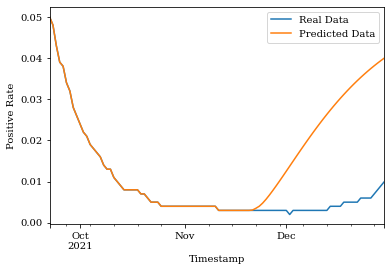

In [ ]:
# from above example we can see that p=0 and q=2 gives least RMSE
model = VARMAX(train[['Positive\_Rate', 'Discharged', 'PCR\_Positive','ComparisonPreSpread']], order=(2,3)).fit( disp=False)
result = model.forecast(steps = 40)
res = inverse_diff(data[['Positive\_Rate', 'Discharged', 'PCR\_Positive','ComparisonPreSpread']],result)
df_pred = pd.DataFrame(res['Positive\_Rate'])
original = pd.DataFrame(df1['Positive\_Rate'][-100:])
original_pred = pd.DataFrame(df1['Positive\_Rate'][-100:-40])
df_pred_plot = pd.concat([original_pred, df_pred])

# plot data
ax = original.plot(legend=True)
df_pred_plot.plot(ax = ax, legend=True)

plt.legend(['Real Data', 'Predicted Data'])
plt.xlabel('Timestamp')
plt.ylabel('Positive Rate')

plt.savefig('VARMA(2,3)_40Days.png', dpi=100)

In [ ]:
rmse = sqrt(mean_squared_error(df_pred, original[-40:]))
print(rmse)

0.021116224311683175


## 80 Days

In [ ]:
X = data.copy()
train, test = X[0:-80], X[-80:]
cols = list(train.columns)

pq = []
for name, column in train[['Positive\_Rate', 'Discharged', 'PCR\_Positive','ComparisonPreSpread']].iteritems():
    print(f'Searching order of p and q for : {name}')
    stepwise_model = auto_arima(train[name],start_p=1, start_q=1,max_p=10, max_q=10, seasonal=False,
        trace=True,error_action='ignore',suppress_warnings=True, stepwise=True,maxiter=1000)
    parameter = stepwise_model.get_params().get('order')
    print(f'optimal order for:{name} is: {parameter} \n\n')
    pq.append(stepwise_model.get_params().get('order'))

Searching order of p and q for : Positive\_Rate
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5059.713, Time=0.33 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4592.760, Time=0.20 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5003.560, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-4835.000, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-4593.580, Time=0.16 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-5005.073, Time=0.58 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-5069.916, Time=0.40 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-4882.695, Time=0.57 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-5072.761, Time=0.48 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-5063.611, Time=0.61 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-5065.814, Time=1.10 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-5069.077, Time=0.66 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-5064.777, Time=0.26 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : 

In [ ]:
df_results_moni = pd.DataFrame()
print('Grid Search Started')
start = timer()
for i in pq:
    if i[0]== 0 and i[2] ==0:
        pass
    else:
        print(f' Running for {i}')
        model = VARMAX(train[['Positive\_Rate', 'Discharged', 'PCR\_Positive','ComparisonPreSpread']], order=(i[0],i[2])).fit(disp=False)
        result = model.forecast(steps = 80)
        inv_res = inverse_diff(data[['Positive\_Rate', 'Discharged', 'PCR\_Positive','ComparisonPreSpread']] , result)
        positive_rate_rmse = np.sqrt(metrics.mean_squared_error(test['Positive\_Rate'], inv_res['Positive\_Rate']))
        df_results_moni = df_results_moni.append({'p': i[0], 'q': i[2], 'RMSE Positive Rate':positive_rate_rmse}, ignore_index=True)
end = timer()
print(f' Total time taken to complete grid search in seconds: {(end - start)}')

Grid Search Started
 Running for (2, 1, 2)
 Running for (6, 1, 6)
 Running for (7, 1, 2)
 Running for (0, 1, 2)
 Total time taken to complete grid search in seconds: 346.62415251899995


In [ ]:
df_results_moni.sort_values(by = ['RMSE Positive Rate'])

,RMSE Positive Rate,p,q
0,0.040032,2.0,2.0
1,0.045623,6.0,6.0
2,0.054194,7.0,2.0
3,0.059586,0.0,2.0


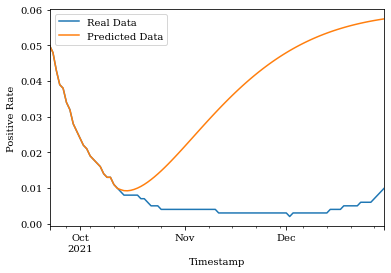

In [ ]:
# from above example we can see that p=0 and q=2 gives least RMSE
model = VARMAX(train[['Positive\_Rate', 'Discharged', 'PCR\_Positive','ComparisonPreSpread']], order=(2,3)).fit( disp=False)
result = model.forecast(steps = 80)
res = inverse_diff(data[['Positive\_Rate', 'Discharged', 'PCR\_Positive','ComparisonPreSpread']],result)
df_pred = pd.DataFrame(res['Positive\_Rate'])
original = pd.DataFrame(df1['Positive\_Rate'][-100:])
original_pred = pd.DataFrame(df1['Positive\_Rate'][-100:-80])
df_pred_plot = pd.concat([original_pred, df_pred])

# plot data
ax = original.plot(legend=True)
df_pred_plot.plot(ax = ax, legend=True)

plt.legend(['Real Data', 'Predicted Data'])
plt.xlabel('Timestamp')
plt.ylabel('Positive Rate')

plt.savefig('VARMA(2,2)_80Days.png', dpi=100)

In [ ]:
rmse = sqrt(mean_squared_error(df_pred, original[-80:]))
print(rmse)

0.03668892924701981


## 20 Days

In [ ]:
X = data.copy()
train, test = X[0:-20], X[-20:]
cols = list(train.columns)

pq = []
for name, column in train[['Positive\_Rate', 'Discharged', 'PCR\_Positive','ComparisonPreSpread']].iteritems():
    print(f'Searching order of p and q for : {name}')
    stepwise_model = auto_arima(train[name],start_p=1, start_q=1,max_p=10, max_q=10, seasonal=False,
        trace=True,error_action='ignore',suppress_warnings=True, stepwise=True,maxiter=1000)
    parameter = stepwise_model.get_params().get('order')
    print(f'optimal order for:{name} is: {parameter} \n\n')
    pq.append(stepwise_model.get_params().get('order'))

Searching order of p and q for : Positive\_Rate
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5697.574, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5178.359, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5634.268, Time=0.18 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5455.562, Time=0.56 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5178.925, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-5636.556, Time=0.65 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-5708.754, Time=0.46 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-5493.131, Time=0.38 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-5712.197, Time=0.51 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-5702.310, Time=0.64 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-5704.836, Time=0.48 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-5708.215, Time=1.20 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-5703.404, Time=0.27 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : 

In [ ]:
df_results_moni = pd.DataFrame()
print('Grid Search Started')
start = timer()
for i in pq:
    if i[0]== 0 and i[2] ==0:
        pass
    else:
        print(f' Running for {i}')
        model = VARMAX(train[['Positive\_Rate', 'Discharged', 'PCR\_Positive','ComparisonPreSpread']], order=(i[0],i[2])).fit(disp=False)
        result = model.forecast(steps = 20)
        inv_res = inverse_diff(data[['Positive\_Rate', 'Discharged', 'PCR\_Positive','ComparisonPreSpread']] , result)
        positive_rate_rmse = np.sqrt(metrics.mean_squared_error(test['Positive\_Rate'], inv_res['Positive\_Rate']))
        df_results_moni = df_results_moni.append({'p': i[0], 'q': i[2], 'RMSE Positive Rate':positive_rate_rmse}, ignore_index=True)
end = timer()
print(f' Total time taken to complete grid search in seconds: {(end - start)}')

Grid Search Started
 Running for (2, 1, 2)
 Running for (2, 1, 2)
 Running for (7, 1, 2)
 Running for (2, 1, 3)
 Total time taken to complete grid search in seconds: 215.65357963199995


In [ ]:
df_results_moni.sort_values(by = ['RMSE Positive Rate'])

,RMSE Positive Rate,p,q
2,0.005304,7.0,2.0
3,0.005607,2.0,3.0
0,0.006360,2.0,2.0
1,0.006360,2.0,2.0


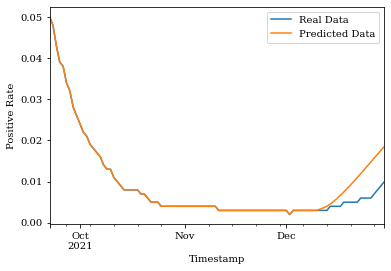

In [ ]:
# from above example we can see that p=0 and q=2 gives least RMSE
model = VARMAX(train[['Positive\_Rate', 'Discharged', 'PCR\_Positive','ComparisonPreSpread']], order=(2,3)).fit( disp=False)
result = model.forecast(steps = 20)
res = inverse_diff(data[['Positive\_Rate', 'Discharged', 'PCR\_Positive','ComparisonPreSpread']],result)
df_pred = pd.DataFrame(res['Positive\_Rate'])
original = pd.DataFrame(df1['Positive\_Rate'][-100:])
original_pred = pd.DataFrame(df1['Positive\_Rate'][-100:-20])
df_pred_plot = pd.concat([original_pred, df_pred])

# plot data
ax = original.plot(legend=True)
df_pred_plot.plot(ax = ax, legend=True)

plt.legend(['Real Data', 'Predicted Data'])
plt.xlabel('Timestamp')
plt.ylabel('Positive Rate')

plt.savefig('VARMA(7,2)_20Days.png', dpi=100)

In [ ]:
rmse = sqrt(mean_squared_error(df_pred, original[-20:]))
print(rmse)

0.005607378669879199
